# Packages import

In [ ]:
import Pkg
Pkg.add("Plots");
Pkg.add("BenchmarkTools");
Pkg.add("ReverseDiff");
Pkg.add("Plots");
Pkg.add("BenchmarkTools");
Pkg.add("SymPy");
Pkg.add("Roots");

## Namespaces

In [1]:
using Plots;
using ReverseDiff
using SymPy, LinearAlgebra;
using BenchmarkTools;
using Roots;

# Structure and functions Definition

In [2]:
abstract type Node end
abstract type LeafNode <: Node end
mutable struct Variable{T} <: LeafNode
    value::T
    grad::T

    Variable(val::T) where T = new{T}(val, 0.001 .* val)
    Variable(val::T, grad::T) where T = new{T}(val, grad)
end


struct ComputableNode{TOperation, TAttributes} <: Node 
    operation::TOperation
    attribute::TAttributes
end

mutable struct CachedNode{TNode, TOutput} <: Node
    node::TNode
    output::TOutput
end

function register(op, args...)
 node = ComputableNode(op, args)
 out = forward(node)
 CachedNode(node, out)
end

import Base: +, -, *, /, sin,cos,tan,exp
import Base: zero, isless
import Base: convert, promote_rule
+(x::Node, y::Node) = register(+, x, y)
-(x::Node, y::Node) = register(-, x, y)
*(x::Node, y::Node) = register(*, x, y)
/(x::Node, y::Node) = register(/, x, y)
sin(x::Node) = register(sin,x)
cos(x::Node) = register(cos,x)
tan(x::Node) = register(tan,x)
exp(x::Node) = register(exp,x)

+(x::Variable{Float64}, y::Float64) = +(value(x), y)
*(x::Variable{Float64}, y::Float64) = *(value(x), y)

forward(cached::CachedNode) = cached.output = forward(cached.node)
forward(node::ComputableNode) = forward(node.operation, map(forward, node.attribute)...)
forward(op::Function, args...) = op(args...)
forward(var::Variable) = var.value
value(x::Variable) = x.value

#Nodes functions
zero(x::Variable) = Variable(0.0, 0.0);
isless(x::Variable{any}, y::Variable{any}) = x.value < y.value;
isless(x::Float64, y::Variable{Float64}) = x < y.value;
isless(x::Int64, y::Variable{Float64}) = x < y.value;

convert(::Type{Variable{T}}, x::Variable) where T =
 Variable(convert(T, x.value), convert(T, x.grad))
convert(::Type{Variable{T}}, x::Number) where T =
 Variable(convert(T, x), zero(T))
promote_rule(::Type{Variable{T}}, ::Type{R}) where {T,R} =
 Variable{promote_type(T,R)}

function fval(f, xv, yv)
 x, y = Variable(xv), Variable(yv)
 z = f(x, y)
 value(z)
end
function fgrad(f, xv, yv)
 x, y = Variable(xv), Variable(yv)
 z = f(x, y)
 backward(z, Variable(1.0))
 5e-4x.grad, 5e-4y.grad
end


function fval(f, xv)
 x = Variable(xv)
 z = f(x)
 value(z)
end
function fgrad(f, xv)
 x = Variable(xv)
 z = f(x)
 backward(z, 1)
 x.grad
end

function backward(cached::CachedNode, grad::Any)
     grad_inputs = gradient(cached, grad)
      for (each, each_grad) in zip(cached.node.attribute, grad_inputs)
        backward(each, each_grad)
      end
      nothing
    end


function backward(var::Variable, grad)
    if isdefined(var, :grad)
            var.grad += grad
    else
            var.grad = grad
     end
        nothing
    end

gradient(cached::CachedNode, grad) =
 gradient(cached.node.operation, grad, map(value, cached.node.attribute)...)
gradient(op::Function, grad, args...) =
 gradient(op, grad, args...)
value(cached::CachedNode) = value(cached.output)
value(var::Variable) = var.value
value(var::Float64) = var
gradient(::typeof(+), grad, x, y) = (grad * (1 + y), grad * (x+1))
gradient(::typeof(-), grad, x, y) = (grad * (1- y), grad * (x-1))
gradient(::typeof(/), grad, x, y) = (grad / y, -1.0 * grad * x / y^2)
gradient(::typeof(*), grad, x, y) = (grad * y, grad * x)
gradient(::typeof(sin), grad, x) = (grad * cos(x), )
gradient(::typeof(cos), grad, x) = (-grad * sin(x), )
gradient(::typeof(tan), grad, x) = (grad/(cos(x)*cos(x)), )
gradient(::typeof(exp), grad, x) = (grad * exp(x), )

function dSoftmaxdx(x::Vector{T}) where {T <: Number}
    derivative_matrix = Matrix{T}[]
     f_value = softmax(x)
    for i =1:length(x)
           col = T[]
         for j =1:length(x)
             if i == j
                   push!(col,f_value[i] * (1.0 - f_value[i]))
             else
                   push!(col, -1.0 * f_value[i] * f_value[j])
             end
         end
            
            push!(derivative_matrix, col[:,:])
        end
        hcat(derivative_matrix...)
    end

function jacobian(f::Function, args::Vector{T}) where {T <:Number}
    jacobian_columns = Matrix{T}[]
    for i=1:length(args)
        x = T[]
        for j=1:length(args)
            if i == j
                push!(x, fgrad(f, args[j]))
            else
                push!(x, 0.0::T)
            end
        end
        push!(jacobian_columns, x[:,:])
    end
    hcat(jacobian_columns...)
end

function jacobian(f::Function, xargs::Vector{T}, yargs::Vector{T}) where {T <:Number}
    xjacobian_columns = Matrix{T}[]
    yjacobian_columns = Matrix{T}[]
    @assert length(xargs) == length(yargs)
    for i=1:length(xargs)
        x = T[]
        y = T[]
        for j=1:length(xargs)
            if i == j
                xval, yval = fgrad(f, xargs[j], yargs[j])
                push!(x, xval)
                push!(y, yval)
            else
                push!(x, 0.0::T)
                push!(y, 0.0::T)
            end
        end
        push!(xjacobian_columns, x[:,:])
        push!(yjacobian_columns, y[:,:])
    end
    hcat(xjacobian_columns...)
    hcat(yjacobian_columns...)
    xjacobian_columns, yjacobian_columns
end

function reverseDerivate(f, x::Array{Float64})
    y = fval.(f, x);
    d = fgrad.(f, x);
    return y,d
end

function reverseDerivate(f, xv::Array{Float64}, yv::Array{Float64})
     zv = fval.(f, xv, yv);
     dz = fgrad.(f, xv[:], yv[:]);
    return zv,dz
end

reverseDerivate (generic function with 2 methods)

# My Extra functions

In [3]:
function isTheSameValues(x::Array{Float64,2} , y::Array{Float64,2})
    #diffrenceArray ::Array{Float64,1} = x - y;
    if x == y
        println("Wyniki są takie same")
    else
        println("Wyniki są różne")
    end
end

function ReLUExactDiv(x)
    if(x <= 0) 
        return 0.0
        else return 1.0
        end
end

function errorValue(yValues::Array{Float64,1} , testValues::Array{Float64,1})
     error = (mean( abs.(yValues - testValues))) / ( mean(testValues))
    println("Wartość błędu wynosi: ");
    println(error);
    return error;
end

function softmaxReverse(A::Array{Float64})
softmax(arg) = exp.(arg) ./ sum(exp.(arg));

y = softmax(A);

d = Vector{Float64}
d = zeros(0)

for i =1:length(A)
    push!(d, y[i] * (1.0 - y[i])) 
end
    return y,d;
end   

    function isTheSameValues(x::Array{Float64,1} , y::Array{Float64,1})
    #diffrenceArray ::Array{Float64,1} = x - y;
    if x == y
        println("Wyniki są takie same")
    else
        println("Wyniki są różne")
    end
end

isTheSameValues (generic function with 2 methods)

# ReLu

## My value 

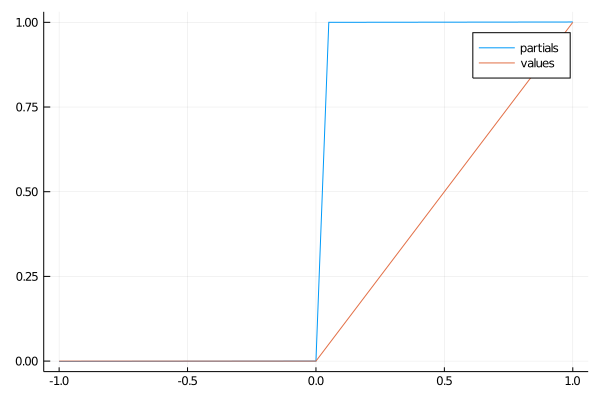

In [4]:
ReLu(x::Variable) = x > 0 ? x : zero(x)
x = collect(-1.0:0.05:1.0);

revY, revD = reverseDerivate(ReLu, x);

plot(x, revD, label = "partials")
plot!(x, revY, label = "values")

## Exact Value - comparation

In [ ]:
exactD = @. ReLUExactDiv(x);

errorValue(exactD, revD)

# Softmax 

## My value 

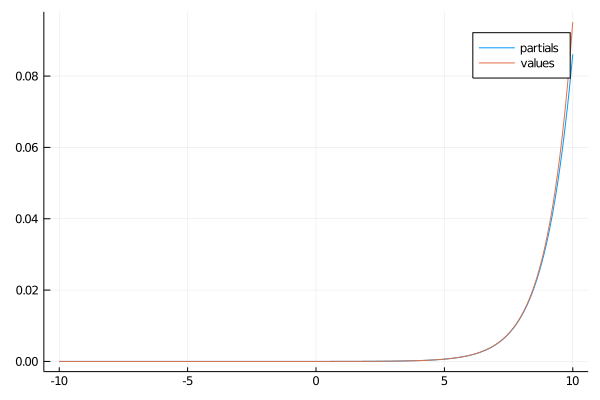

In [5]:
softmax(arg) = exp.(arg) ./ sum(exp.(arg));

A = collect(-10.0:0.1:10.0);
y = softmax(A);

d = Vector{Float64}
d = zeros(0)

for i =1:length(A)
    push!(d, y[i] * (1.0 - y[i])) 
end

plot(A, d, label = "partials")
plot!(A, y, label = "values")

In [ ]:
@benchmark softmaxReverse(A);

# Sinus

## My value 

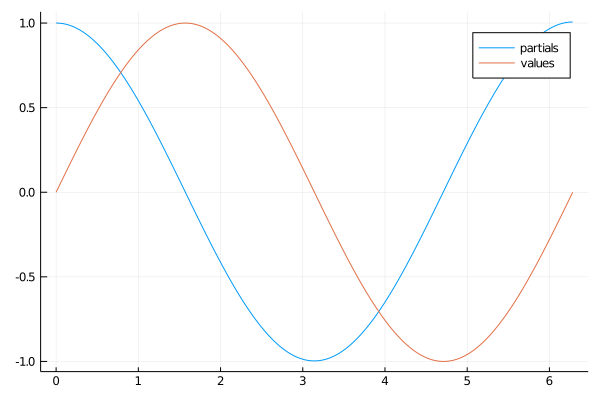

In [6]:
range =  collect(0:π/360:2*π);
sinY, sinD = reverseDerivate(sin, range);

plot(range, sinD, label = "partials")
plot!(range, sinY, label = "values")

##  Exact Value - comparation

In [ ]:
x = symbols("x", real=true) # also integer, positive, negative...
f = sin(x)
dSin = diff(f,x);
dSin = convert(Function, dSin);
exactValue = dSin.(range);

isTheSameValues(sinD, exactValue)

errorValue(exactValue, sinD)

# Cosiuns

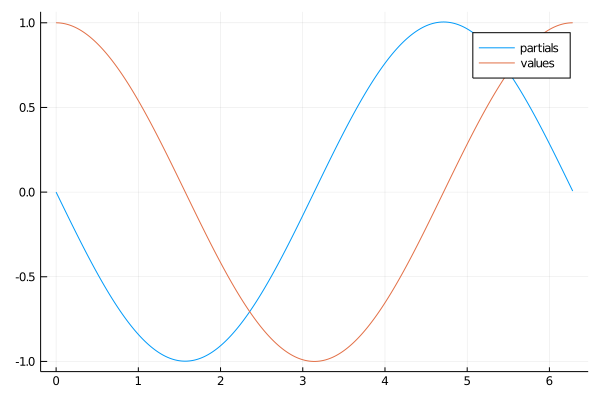

In [7]:
range =  collect(0:π/360:2*π);

cosY, cosD = reverseDerivate(cos, range);

plot(range,  cosD, label = "partials")
plot!(range, cosY, label = "values")

##  Exact Value - comparation

In [ ]:
x = symbols("x", real=true) # also integer, positive, negative...
f = cos(x)
dCos = diff(f,x);
dCos = convert(Function, dCos);
exactValue = dCos.(range);

isTheSameValues(cosD, exactValue)
errorValue(exactValue, cosD);


# Tanges

## My value

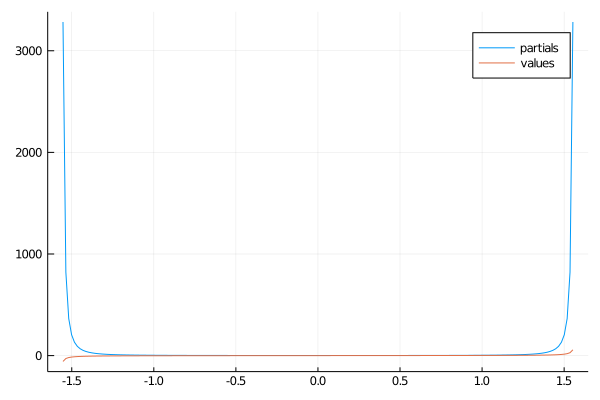

In [8]:
rangeTan =  collect(-π/2+π/180:π/180:π/2- π/180)
tanY, tanD = reverseDerivate(tan, rangeTan);

plot(rangeTan, tanD, label = "partials")
plot!(rangeTan, tanY, label = "values")

## Exact Value - comparation 

In [ ]:
x = symbols("x", real=true) # also integer, positive, negative...
f = tan(x);
dTan = diff(f,x);
dTan = convert(Function, dTan);

exactValue = dTan.(rangeTan);

isTheSameValues(exactValue, tanD);

errorValue(exactValue, tanD);

## Rosenbrock 

## My value 

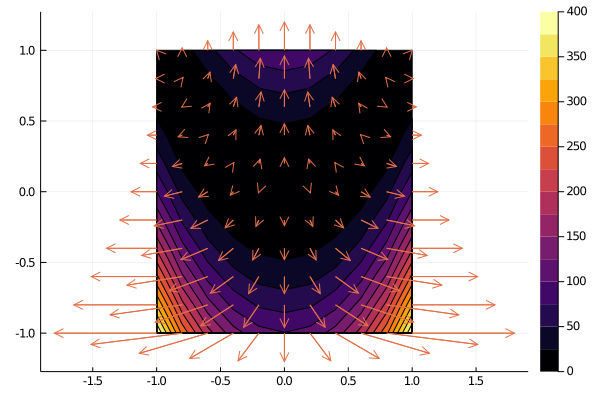

In [9]:
v = -1:.2:+1;
n = length(v);
xv = repeat(v, inner=n);
yv = repeat(v, outer=n);

rosenbrock(x, y) = (Variable(1.0) - x*x) + Variable(100.0)*(y - x*x)*(y - x*x)
zv, dz = reverseDerivate(rosenbrock, xv, yv);

zv = reshape(zv, n, n)
contour(v, v, zv, fill=true)
quiver!(xv[:], yv[:], gradient=dz)

## Exact value - comparation 

In [ ]:
rosenbrock(x, y) = (1.0 - x*x) + 100.0*(y - x*x)*(y - x*x);

x,y = symbols("x, y", real=true)

f = rosenbrock(x,y)
dxRosenbrock = diff(f,x);
dxRosenbrock = convert(Function, dxRosenbrock);
dyRosenbrock = diff(f,y);
dyRosenbrock = convert(Function, dyRosenbrock);
dxExactValue = 5e-4 *dxRosenbrock.(xv, yv);
dyExactValue = 5e-4 *dyRosenbrock.(xv, yv);

dx = first.(dz);
dy = last.(dz);

println("Porównanie dx: ");
isTheSameValues(dx, dxExactValue);
dxError = errorValue(dxExactValue, dx);
println();

println("Porównanie dy: ");
isTheSameValues(dy, dyExactValue);
dyError = errorValue(dyExactValue, dy);

println();
println("Średnia wartość błędu ");
mean([dxError, dyError])


# Jacobian

In [12]:
    x = [i for i in -1.0:0.5:1];
    range = [i for i in 0:π/360:2*π] ;
    rangeTan = [i for i in -π/2+π/180:π/180:π/2- π/180];

    v = -1:0.2:+1
    n = length(v)
    xv = repeat(v, inner=n)
    yv = repeat(v, outer=n)

    display("Jacobi Relu")
    y = jacobian(ReLu,x);
    display(y)

    display("Jacobi Sin")
    y = jacobian(sin, range);
    display(y)

    display("Jacobi Cos")
    y = jacobian(cos, range);
    display(y)

    display("Jacobi Tan")
    y = jacobian(tan, rangeTan);
    display(y)

    display("Jacobi Rosenbrock")
    dx, dy = jacobian(rosenbrock, xv, yv)
    display(dx)

"Jacobi Relu"

5×5 Array{Float64,2}:
 -0.001   0.0     0.0  0.0     0.0
  0.0    -0.0005  0.0  0.0     0.0
  0.0     0.0     0.0  0.0     0.0
  0.0     0.0     0.0  1.0005  0.0
  0.0     0.0     0.0  0.0     1.001

"Jacobi Sin"

721×721 Array{Float64,2}:
 1.0  0.0       0.0       0.0       …  0.0      0.0      0.0      0.0
 0.0  0.999971  0.0       0.0          0.0      0.0      0.0      0.0
 0.0  0.0       0.999865  0.0          0.0      0.0      0.0      0.0
 0.0  0.0       0.0       0.999684     0.0      0.0      0.0      0.0
 0.0  0.0       0.0       0.0          0.0      0.0      0.0      0.0
 0.0  0.0       0.0       0.0       …  0.0      0.0      0.0      0.0
 0.0  0.0       0.0       0.0          0.0      0.0      0.0      0.0
 0.0  0.0       0.0       0.0          0.0      0.0      0.0      0.0
 0.0  0.0       0.0       0.0          0.0      0.0      0.0      0.0
 0.0  0.0       0.0       0.0          0.0      0.0      0.0      0.0
 0.0  0.0       0.0       0.0       …  0.0      0.0      0.0      0.0
 0.0  0.0       0.0       0.0          0.0      0.0      0.0      0.0
 0.0  0.0       0.0       0.0          0.0      0.0      0.0      0.0
 ⋮                                  ⋱                           

"Jacobi Cos"

721×721 Array{Float64,2}:
 0.0   0.0          0.0        0.0        …  0.0        0.0       0.0
 0.0  -0.00871781   0.0        0.0           0.0        0.0       0.0
 0.0   0.0         -0.017435   0.0           0.0        0.0       0.0
 0.0   0.0          0.0       -0.0261508     0.0        0.0       0.0
 0.0   0.0          0.0        0.0           0.0        0.0       0.0
 0.0   0.0          0.0        0.0        …  0.0        0.0       0.0
 0.0   0.0          0.0        0.0           0.0        0.0       0.0
 0.0   0.0          0.0        0.0           0.0        0.0       0.0
 0.0   0.0          0.0        0.0           0.0        0.0       0.0
 0.0   0.0          0.0        0.0           0.0        0.0       0.0
 0.0   0.0          0.0        0.0        …  0.0        0.0       0.0
 0.0   0.0          0.0        0.0           0.0        0.0       0.0
 0.0   0.0          0.0        0.0           0.0        0.0       0.0
 ⋮                                        ⋱                     

"Jacobi Tan"

179×179 Array{Float64,2}:
 3283.14    0.0      0.0      0.0    …    0.0      0.0      0.0       0.0
    0.0   821.033    0.0      0.0         0.0      0.0      0.0       0.0
    0.0     0.0    365.088    0.0         0.0      0.0      0.0       0.0
    0.0     0.0      0.0    205.508       0.0      0.0      0.0       0.0
    0.0     0.0      0.0      0.0         0.0      0.0      0.0       0.0
    0.0     0.0      0.0      0.0    …    0.0      0.0      0.0       0.0
    0.0     0.0      0.0      0.0         0.0      0.0      0.0       0.0
    0.0     0.0      0.0      0.0         0.0      0.0      0.0       0.0
    0.0     0.0      0.0      0.0         0.0      0.0      0.0       0.0
    0.0     0.0      0.0      0.0         0.0      0.0      0.0       0.0
    0.0     0.0      0.0      0.0    …    0.0      0.0      0.0       0.0
    0.0     0.0      0.0      0.0         0.0      0.0      0.0       0.0
    0.0     0.0      0.0      0.0         0.0      0.0      0.0       0.0
    ⋮       

"Jacobi Rosenbrock"

121-element Array{Array{Float64,2},1}:
 [-0.8000005; 0.0; … ; 0.0; 0.0]
 [0.0; -0.6480005; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 ⋮
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.008000499999999997; 0.0]
 [0.0; 0.0; … ; 0.0; 5.0e-7]